In [1]:
import tensorflow as tf

In [2]:
!nvidia-smi

Tue Apr 22 00:23:07 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 572.83                 Driver Version: 572.83         CUDA Version: 12.8     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   47C    P3             11W /   30W |       0MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, Concatenate
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix , classification_report
import cv2
import os
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import itertools
from tensorflow.keras.callbacks import EarlyStopping
import contextlib
from datetime import datetime
from IPython import get_ipython
from sklearn.decomposition import PCA

In [5]:
import sys
sys.path.append('../../../utils')  # Add the folder to the path
from notebook_saver import NotebookSaver

Import data

In [6]:
run_start_index = len(get_ipython().user_ns['In'])

# References: https://pythonprogramming.net/convolutional-neural-network-deep-learning-python-tensorflow-keras/
DATADIR = r"C:\Users\New Asus\Documents\FIT4701_2025_Sem1\training_img_dataset\front_dataset\front_micro\dwt_training_picture"
CATEGORIES = ["clap", "punching", "pushpull", "rubhand", "waving"]

notebook_saver = NotebookSaver()
save_dir = notebook_saver.get_save_dir()

for category in CATEGORIES:
    path = os.path.join(DATADIR,category)
    for img in os.listdir(path):
        img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)
        break
    break 

IMG_SIZE = 64

new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))

training_data = []

def create_training_data():
    for category in CATEGORIES:

        path = os.path.join(DATADIR,category)
        class_num = CATEGORIES.index(category)

        for img in tqdm(os.listdir(path)):
            try:
                img_array = cv2.imread(os.path.join(path,img) ,cv2.IMREAD_GRAYSCALE)
                new_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE)) 
                training_data.append([new_array, class_num])
            except Exception as e:
                pass

create_training_data()
print(len(training_data))


Save directory created: notebook_versions\20250422_002311_notebookversion


100%|██████████| 1210/1210 [00:03<00:00, 367.08it/s]

6094


In [7]:
import random

random.shuffle(training_data)

In [8]:
X = []
y = []

for features,label in training_data:
    X.append(features)
    y.append(label)
    
X = np.array(X).reshape(-1, IMG_SIZE, IMG_SIZE, 1)
y = np.array(y)

In [9]:
import pickle

pickle_out = open("X.pickle","wb")
pickle.dump(X, pickle_out)
pickle_out.close()

pickle_out = open("y.pickle","wb")
pickle.dump(y, pickle_out)
pickle_out.close()

pickle_in = open("X.pickle","rb")
X = pickle.load(pickle_in)

pickle_in = open("y.pickle","rb")
y = pickle.load(pickle_in)

Data Normalization

In [10]:
X = X/255.0
y = to_categorical(y, num_classes=5)

Split training set and validation set

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

Early stopping

In [12]:
# early stopping for preventing overfitting
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

Apply CNN model

In [13]:
cnn = tf.keras.models.Sequential([
    
    # References: Using dropouts in conv layers: https://link.springer.com/chapter/10.1007/978-3-319-54184-6_12#Sec4 
    tf.keras.layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(64, 64, 1)),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.MaxPooling2D((2, 2)),
    
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'), # Hybrid dropouts
    tf.keras.layers.Dropout(0.5), # References: Improving neural networks by preventing co-adaptation of feature detectors: https://arxiv.org/pdf/1207.0580 
    tf.keras.layers.Dense(5, activation='softmax')
])

cnn.compile(Adam(learning_rate = 0.0001),  
            loss='categorical_crossentropy',
            metrics=['accuracy'])

history = cnn.fit(X_train, y_train, epochs=200, batch_size=64, validation_data=(X_val, y_val), callbacks=[early_stopping])

val_loss, val_acc = cnn.evaluate(X_val, y_val) 
print(f"Final Validation Accuracy: {val_acc}")

Epoch 1/200
77/77 [==============================] - 38s 136ms/step - loss: 1.6130 - accuracy: 0.2057 - val_loss: 1.6028 - val_accuracy: 0.2551
Epoch 2/200
77/77 [==============================] - 2s 26ms/step - loss: 1.5858 - accuracy: 0.2689 - val_loss: 1.5849 - val_accuracy: 0.3462
Epoch 3/200
77/77 [==============================] - 2s 25ms/step - loss: 1.5446 - accuracy: 0.3093 - val_loss: 1.5467 - val_accuracy: 0.3692
Epoch 4/200
77/77 [==============================] - 2s 26ms/step - loss: 1.4835 - accuracy: 0.3458 - val_loss: 1.4731 - val_accuracy: 0.4258
Epoch 5/200
77/77 [==============================] - 2s 26ms/step - loss: 1.3958 - accuracy: 0.3977 - val_loss: 1.4149 - val_accuracy: 0.4520
Epoch 6/200
77/77 [==============================] - 2s 26ms/step - loss: 1.3469 - accuracy: 0.4189 - val_loss: 1.3873 - val_accuracy: 0.4463
Epoch 7/200
77/77 [==============================] - 2s 26ms/step - loss: 1.3165 - accuracy: 0.4427 - val_loss: 1.3582 - val_accuracy: 0.4791
Epoc

Plot loss and accuracy graph

Plot saved to: notebook_versions\20250422_002311_notebookversion\plot_20250422_002929.png


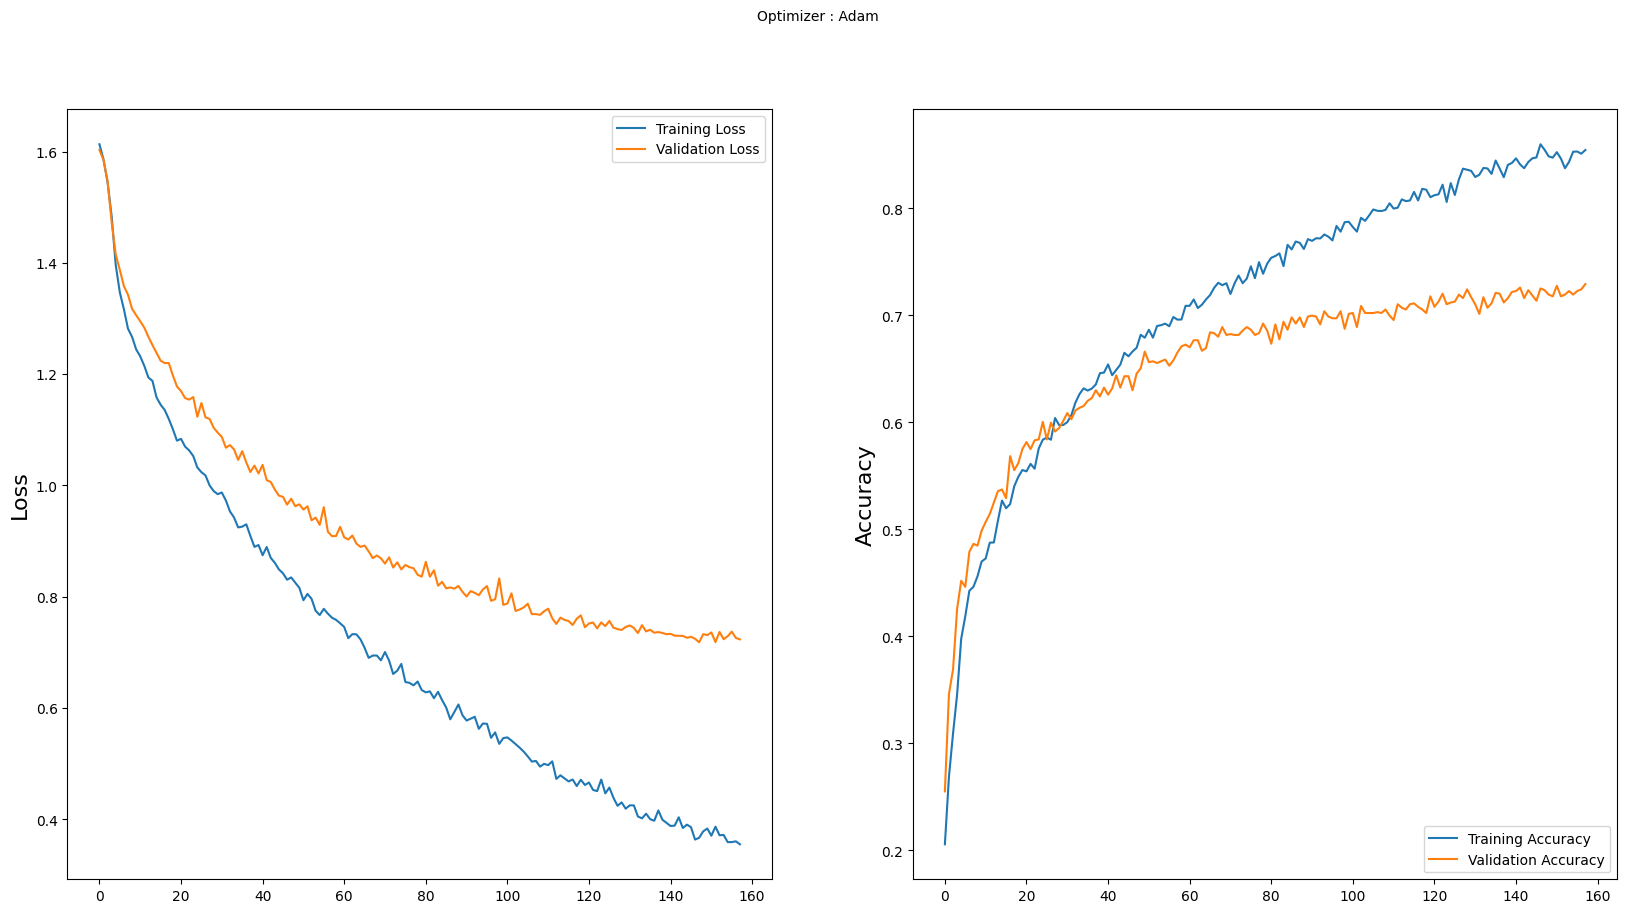

In [14]:
plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1,2,2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
notebook_saver.save_plot(name = 'plot')
plt.show()

Plot confusion matrix

39/39 [==============================] - 1s 9ms/step
Plot saved to: notebook_versions\20250422_002311_notebookversion\cm_20250422_002934.png


<Figure size 640x480 with 0 Axes>

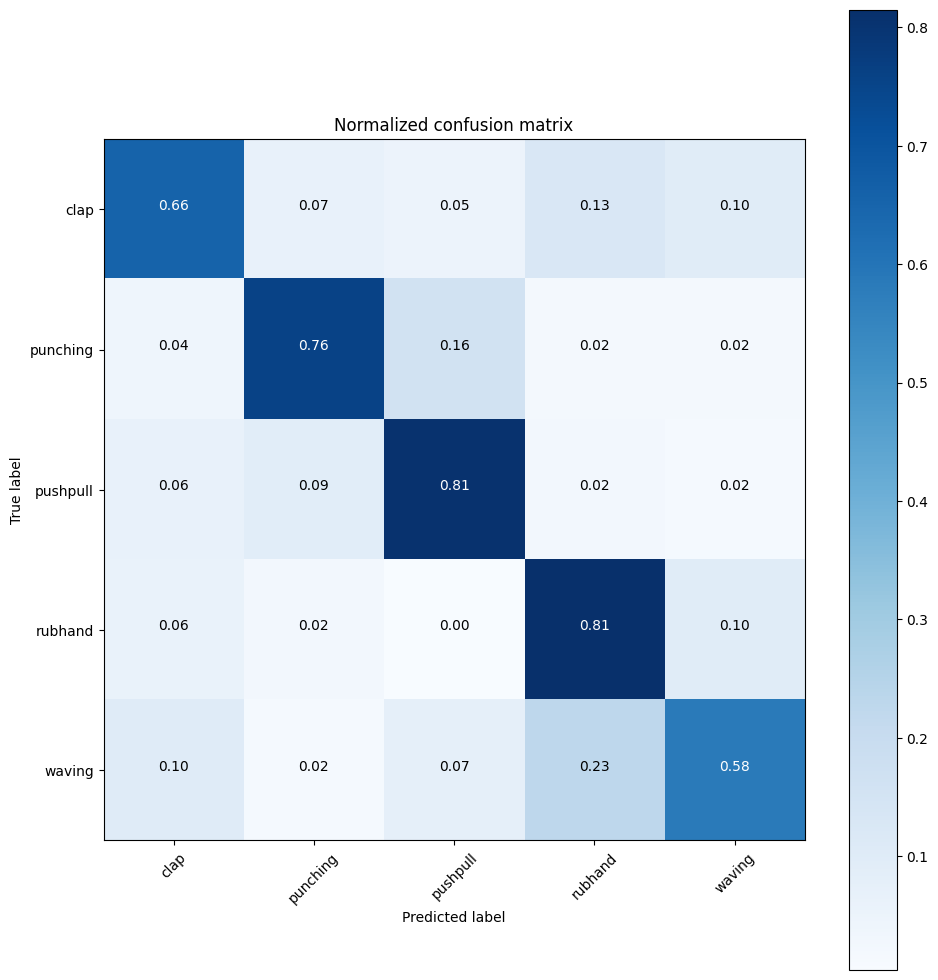

In [15]:
# Plot confusion matrix:
# Get predictions from the model on the validation set
y_pred_probs = cnn.predict(X_val)

y_pred = np.argmax(y_pred_probs, axis=1)  # Convert probabilities to class indices

# Convert one-hot encoded true labels to class indices
y_true = np.argmax(y_val, axis=1)

# Reference: https://github.com/parisafm/CSI-HAR-Dataset/blob/main/CNN.py
def plot_confusion_matrix(cm, classes, title='Confusion matrix', cmap=plt.cm.Blues):
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i,j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i,j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    notebook_saver.save_plot(name = 'cm')

# Compute the confusion matrix
cm = confusion_matrix(y_true, y_pred)

np.set_printoptions(precision=2)

# plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=CATEGORIES, title='Normalized confusion matrix')
plt.show()

Model summary

In [16]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 dropout (Dropout)           (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 64)        18496     
                                                                 
 dropout_1 (Dropout)         (None, 29, 29, 64)        0         
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 64)       0         
 2D)                                                    

Model classfication report

In [17]:
report = classification_report(y_true, y_pred, target_names=CATEGORIES)
print("Classification Report:\n")
print(report)

Classification Report:

              precision    recall  f1-score   support

        clap       0.72      0.66      0.69       253
    punching       0.78      0.76      0.77       226
    pushpull       0.74      0.81      0.77       244
     rubhand       0.68      0.81      0.74       254
      waving       0.70      0.58      0.64       242

    accuracy                           0.72      1219
   macro avg       0.73      0.72      0.72      1219
weighted avg       0.72      0.72      0.72      1219



Unused part

In [18]:
# # 1. Create the Feature Extractor Model from the trained CNN
# #    We take layers up to Flatten (index -3)
# if len(cnn.layers) < 3:
#     print("Error: CNN model is too shallow for feature extraction at Flatten layer.")
# else:
#     feature_extractor = Model(inputs=cnn.input,
#                               outputs=cnn.layers[-3].output, # Output of the Flatten layer
#                               name="CNN_Feature_Extractor")
#     feature_extractor.summary() # Show the structure of the extractor

#     # 2. Extract Features
#     print("\n--- Extracting features using the trained CNN ---")
#     print("Extracting features from training data...")
#     X_train_features = feature_extractor.predict(X_train)
#     print("Extracting features from validation data...")
#     X_val_features = feature_extractor.predict(X_val)

#     print(f"Shape of extracted features (train): {X_train_features.shape}") # e.g., (num_samples, num_flattened_features)
#     print(f"Shape of extracted features (validation): {X_val_features.shape}")

#     # 3. Apply PCA
#     n_components = 64 # Hyperparameter: Choose number of components (e.g., 50, 64, 128, or based on explained variance)
#     if X_train_features.shape[1] < n_components:
#         print(f"Warning: n_components ({n_components}) is >= number of features ({X_train_features.shape[1]}). Setting n_components to {X_train_features.shape[1] - 1}.")
#         n_components = X_train_features.shape[1] - 1 if X_train_features.shape[1] > 1 else 1


#     if n_components > 0: # Proceed only if PCA makes sense
#         pca = PCA(n_components=n_components, random_state=42)

#         print(f"\n--- Applying PCA to reduce dimensionality to {n_components} components ---")
#         print("Fitting PCA on extracted training features...")
#         pca.fit(X_train_features) # Fit ONLY on training data

#         print("Transforming features using PCA...")
#         X_train_pca = pca.transform(X_train_features)
#         X_val_pca = pca.transform(X_val_features)

#         print(f"Shape after PCA (train): {X_train_pca.shape}")
#         print(f"Shape after PCA (validation): {X_val_pca.shape}")
#         print(f"Explained variance ratio by {n_components} components: {np.sum(pca.explained_variance_ratio_):.4f}")


#         # 4. Train a Simpler Classifier (Simple MLP) on PCA features
#         print("\n--- Defining and Training a Simple MLP on PCA features ---")
#         mlp_on_pca = tf.keras.models.Sequential([
#             tf.keras.layers.Input(shape=(n_components,)), # Input shape is now n_components
#             tf.keras.layers.Dense(32, activation='relu'),   # Smaller Dense layer
#             tf.keras.layers.Dropout(0.3),                   # Optional Dropout
#             tf.keras.layers.Dense(len(CATEGORIES), activation='softmax') # Output layer
#         ], name="MLP_on_PCA_Features")

#         mlp_on_pca.compile(Adam(learning_rate = 0.001), # Can use slightly higher LR maybe
#                            loss='categorical_crossentropy',
#                            metrics=['accuracy'])

#         mlp_on_pca.summary()

#         # Use early stopping for the MLP as well
#         mlp_early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True) # Shorter patience maybe

#         history_mlp = mlp_on_pca.fit(X_train_pca, y_train, # Use PCA features and original one-hot labels
#                                      epochs=40, # Train for fewer epochs maybe
#                                      batch_size=64,
#                                      validation_data=(X_val_pca, y_val),
#                                      callbacks=[mlp_early_stopping])


#         # 5. Evaluate the MLP on PCA features
#         print("\n--- Evaluating the Simple MLP on PCA features ---")
#         val_loss_mlp, val_acc_mlp = mlp_on_pca.evaluate(X_val_pca, y_val)
#         print(f"MLP on PCA Features - Final Validation Loss: {val_loss_mlp}")
#         print(f"MLP on PCA Features - Final Validation Accuracy: {val_acc_mlp}")


#         # --- Optional: Plotting for MLP on PCA ---
#         print("\n--- Plotting MLP on PCA History ---")
#         plt.figure(figsize=(12, 5))
#         plt.subplot(1, 2, 1)
#         plt.ylabel('Loss', fontsize=14)
#         plt.plot(history_mlp.history['loss'], label='Training Loss')
#         plt.plot(history_mlp.history['val_loss'], label='Validation Loss')
#         plt.legend(loc='upper right')
#         plt.title('MLP on PCA Features Loss')

#         plt.subplot(1, 2, 2)
#         plt.ylabel('Accuracy', fontsize=14)
#         plt.plot(history_mlp.history['accuracy'], label='Training Accuracy')
#         plt.plot(history_mlp.history['val_accuracy'], label='Validation Accuracy')
#         plt.legend(loc='lower right')
#         plt.title('MLP on PCA Features Accuracy')
#         plt.tight_layout()
#         notebook_saver.save_plot(name='mlp_on_pca_plot')
#         plt.show()


#         # --- Optional: Confusion Matrix for MLP on PCA ---
#         print("\n--- Generating Confusion Matrix for MLP on PCA ---")
#         y_pred_probs_mlp = mlp_on_pca.predict(X_val_pca)
#         y_pred_mlp = np.argmax(y_pred_probs_mlp, axis=1)
#         # y_true is the same as before (from original y_val)

#         # Compute confusion matrix
#         cm_mlp = confusion_matrix(y_true, y_pred_mlp)

#         # Plot normalized confusion matrix
#         plot_confusion_matrix(cm_mlp, classes=CATEGORIES, title='MLP on PCA Features - Normalized Confusion Matrix')
#         plt.show()

#         # Classification Report for MLP on PCA
#         print("\n--- Classification Report for MLP on PCA Features ---")
#         report_mlp = classification_report(y_true, y_pred_mlp, target_names=CATEGORIES, zero_division=0)
#         print(report_mlp)

#     else: # Case where n_components <= 0
#          print("\nSkipping PCA and MLP training because n_components is not positive.")

In [19]:
# Final Comparison
# print("\n\n--- Final Accuracy Comparison ---")
# print(f"Original CNN Final Validation Accuracy: {val_acc:.4f}")
# if 'val_acc_mlp' in locals(): # Check if MLP was trained
#     print(f"MLP on PCA Features Validation Accuracy: {val_acc_mlp:.4f}")
# else:
#     print("MLP on PCA Features was not run.")

# print("\n--- Script Finished ---")


Save code, model summary and training output

In [20]:
notebook_saver.save_notebook_code(run_start_index)
notebook_saver.save_model_summary(cnn)
notebook_saver.save_training_output(history, val_loss, val_acc)

Current notebook cell saved to: notebook_versions\20250422_002311_notebookversion\notebook_code_snapshot.py
Model summary saved to: notebook_versions\20250422_002311_notebookversion\model_summary.txt
Training output saved to: notebook_versions\20250422_002311_notebookversion\training_output.txt
